##**First-Derivative Saliency (Explainability) Method for a Text PerturbationAttack**
### Explainability Methods for Neural Networks - WS 2020/2021###
**Janaki Viswanathan - 2581499**

---



In [1]:
# Loading required packages
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim.downloader as api

import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer

import sys
import random 
import spacy
import string
import matplotlib.pyplot as plt
import numpy as np
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Defining data fields for pre-processing
# Tokenizer : spaCy
# Case      : lower

SEED = 31321

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TEXT = data.Field(tokenize = 'spacy', include_lengths = True, lower=True)
LABEL = data.LabelField(dtype = torch.float)

In [3]:
# Loading Train and Test sets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

# Creating a Validation set from the Train set
train_data, valid_data = train_data.split(random_state = random.seed(SEED), split_ratio=0.7)

print(f'Number of training examples: {len(train_data)}') # 17500
print(f'Number of validation examples: {len(valid_data)}') # 7500
print(f'Number of testing examples: {len(test_data)}') # 25000

aclImdb_v1.tar.gz:   0%|          | 115k/84.1M [00:00<01:15, 1.11MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 55.8MB/s]


Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [4]:
# Building vocabulary for the train set based on pre-trained GloVe embeddings
# Pre-trained word embedding : GloVe with 6 billion tokens and 100 dimensional vectors
# Unknown tokens             : initialised using normal distribution

MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_) 
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399995/400000 [00:20<00:00, 19221.61it/s]

In [5]:
# Building iterators
# Batch size  : 64

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [6]:
# Model architecture
# 1st layer   : biLSTM
# 2nd layer   : biLSTM
# 3rd layer   : dense linear layer
# Regularizer : Dropout

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        
        # LSTM layer
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        # dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(text)
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)

In [7]:
# The model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [8]:
# Pre-trained word embeddings
pretrained_embedding = TEXT.vocab.vectors  # [25002, 100]
# Initialising the pad an unk tokens to zero vectors
TEXT.vocab.vectors[0] = TEXT.vocab.vectors[1] = torch.zeros(EMBEDDING_DIM)

# Embedding layer
embed = nn.Embedding(INPUT_DIM, EMBEDDING_DIM, padding_idx=PAD_IDX).to(device)
#embed.weight.data.copy_(pretrained_embedding)

In [9]:
# Initialising the pad an unk tokens to zero vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
embed.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
embed.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)

In [10]:
# Optimizer and Criterion
# Optimizer : Adam optimizer
# Criterion : Binary cross entropy loss on a sigmoid bounded output

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [11]:
# Accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [12]:
# Train
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        raw_text, text_lengths = batch.text
        text = torch.tensor(embed(raw_text), requires_grad=False)
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
# Evaluation
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            raw_text, text_lengths = batch.text
            text = torch.tensor(embed(raw_text), requires_grad=False)
            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
# Logging the time for each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
# Training the model
N_EPOCHS = 5
best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
train_acc_list  = []
valid_acc_list  = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'base-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 0.696 | Train Acc: 51.64%
	 Val. Loss: 0.689 |  Val. Acc: 51.44%
Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.690 | Train Acc: 53.31%
	 Val. Loss: 0.685 |  Val. Acc: 52.13%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 0.676 | Train Acc: 57.19%
	 Val. Loss: 0.614 |  Val. Acc: 67.61%
Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.620 | Train Acc: 66.00%
	 Val. Loss: 0.579 |  Val. Acc: 70.98%
Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 0.570 | Train Acc: 70.58%
	 Val. Loss: 0.552 |  Val. Acc: 72.16%


In [34]:
# Plotting 
# Plot for losses
def plot_loss(plt, train_loss, test_loss, xtick_num=2):
    n_iter = len(train_loss)
    iterations = [n+1 for n in range(n_iter)]
    plt.plot(iterations, train_loss, label='Train loss')
    plt.plot(iterations, test_loss,  label='Valid loss')
    plt.set_xlabel('Epochs')
    plt.set_xticks([n+1 for n in range(0, len(iterations), xtick_num)])
    plt.set_ylabel('Loss')
    #plt.title("Train and Validation loss across epochs")
    plt.legend();

# Plot for accuracy
def plot_accuracy(plt, train_acc, test_acc, xtick_num=2):
    n_iter = len(train_acc)
    iterations = [n+1 for n in range(n_iter)]
    plt.plot(iterations, train_acc, label='Train acc')
    plt.plot(iterations, test_acc,  label='Valid acc')
    plt.set_xlabel('Epochs')
    plt.set_xticks([n+1 for n in range(0, len(iterations), xtick_num)])
    plt.set_ylabel('Accuracy')
    #plt.title("Train and Validation accuracy across epochs")
    plt.legend();

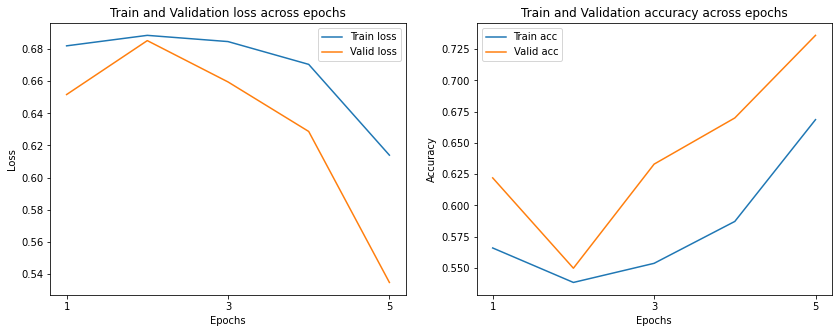

In [17]:
# Plotting accuracy and loss for train and validation sets
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches((14, 5))
ax0.set_title("Train and Validation loss across epochs")
ax1.set_title("Train and Validation accuracy across epochs")
plot_loss(ax0, train_loss_list, valid_loss_list)
plot_accuracy(ax1, train_acc_list, valid_acc_list)

In [36]:
# Predicting on the test set
model.load_state_dict(torch.load('base-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Test Loss: 0.546 | Test Acc: 72.42%


In [19]:
# Prediction on an input text
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    #sentence = sentence.lower()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    embedded = torch.tensor(embed(tensor),requires_grad=False)
    prediction = torch.sigmoid(model(embedded, length_tensor))
    return prediction.item()

In [20]:
# Preprocessing the text to calculate input saliency
embed = nn.Embedding(len(TEXT.vocab), EMBEDDING_DIM, padding_idx = PAD_IDX).to(device)

def pre_process(sentence):
    #sentence = sentence.lower()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    length_tensor = torch.LongTensor(length)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1) # seq_len * batch_size(1)
    embedded = torch.tensor(embed(tensor),requires_grad=True) 
    return tokenized, embedded, length_tensor

In [21]:
# Input saliency
def input_saliency(input_text, model):
  print(f"Input text:{input_text}")
  tokens, preprocessed_text, length_tensor = pre_process(input_text)
  print(f"Tokens:{tokens}")

  model.train()
  model.dropout.eval()
  scores = (model(preprocessed_text, length_tensor))
  scores.backward()

  saliency = preprocessed_text.grad.data.abs().squeeze()
  saliency_list = saliency.detach().cpu().numpy()
  #print(f"Saliency_list:{saliency_list}")
  saliency_tok,_=torch.max(preprocessed_text.grad.data.abs(),dim=2)
  
  pred = predict_sentiment(model, input_text)
  print(f"Prediction:{pred}")
  print(f"Saliency:{saliency_tok}")
  return tokens, preprocessed_text, saliency_tok, scores, saliency_list

In [22]:
# Loading GloVe vectors
#glove_preTrained=api.load("glove-twitter-25")
glove_preTrained=api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [23]:
# Replacing important words with GloVe equivalent
stop_words = stopwords.words('english')

def glove_replace(input_text, saliency_dict):
  list_len = len(saliency_dict)
  tweaked_text = input_text

  for i in range(list_len):
    tok = saliency_dict[i][0]
    if tok.lower() not in string.punctuation and tok.lower() not in stop_words:
      gloveWord = glove_preTrained.most_similar(tok)[0]
      print(f"{tok} ---> {gloveWord}")
      tweaked_text = tweaked_text.replace(tok, gloveWord[0])
  return tweaked_text

In [37]:
# Input sentence
#text = "The movie is fantastic I really like it."
#text = "This film is absolutely appalling and awful. It's not low budget, it's a no budget film."
text = "This film is excellent"
#text = "I hate the movie!"
#text = text = """I wish I knew what to make of a movie like this. I must say that the scenes on the beach struck me as so stereotypical in so many ways. The film devolves into a succession of visual displays and not too much else. A disappointment."""
#text = "This film is horrible!"
#text = "This movie was sadly under-promoted but proved to be truly exceptional."
#text = "'how did this ever come  into existence ? The effects were sad, the lines were sadder. Avoid at all costs. The idea of the film is actually a good one. There was a lot of potential to make a great little movie here. I just don't understand how something like this ends up like this. Go speak to the film / arts / english interested students in any high school and you'll find people who can write a better script.'"
#model.to(device)
#text = text.to(device)
print(f"Input text: {text}")
print(f"Model prediction: {predict_sentiment(model, text)}")

Input text: This film is excellent
Model prediction: 0.7483808398246765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [44]:
# Calculating input saliency
tokens, preprocessed_text, saliency, scores, saliency_list = input_saliency(text, model)

Input text:This film is excellent
Tokens:['This', 'film', 'is', 'excellent']
Prediction:0.7259778380393982
Saliency:tensor([[0.0773],
        [0.0949],
        [0.1725],
        [0.1944]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


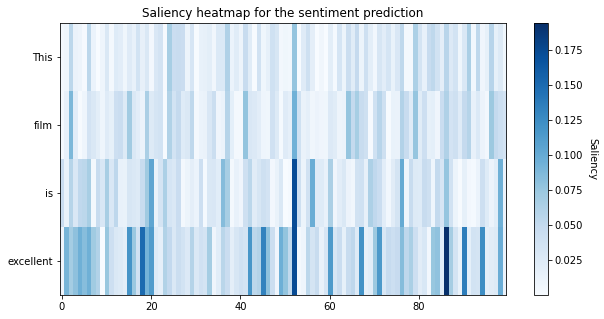

In [45]:
# Saliency heat map
plt.switch_backend('agg')

words = [tok.text for tok in nlp.tokenizer(text)]
# Create the figure
fig = plt.figure(figsize=(10, 5))
# Set the sub-figure
ax = fig.add_subplot(111)
ax.set_aspect(aspect=2)
im = plt.imshow(saliency_list, aspect='auto',interpolation='nearest', cmap=plt.cm.Blues)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Saliency", rotation=-90, va="bottom")
# Set ticks for axis
ax.set_yticks(np.arange(len(words)))
ax.set_xticks(np.arange(len(saliency_list[0]),step = 20))
ax.set_yticklabels(words)
ax.set_title("Saliency heatmap for the sentiment prediction")
plt.savefig( 'SaliencyHeatmap_'+text[0:50]+'.pdf', format='pdf')

In [27]:
# Important words
saliency_tok_list = saliency.tolist()
saliency_dict = dict(zip(tokens,saliency_tok_list))
saliency_dict = sorted(saliency_dict.items(), key=lambda item: item[1], reverse=True)
saliency_dict

[('is', [0.08372390270233154]),
 ('This', [0.08335263282060623]),
 ('film', [0.06710473448038101]),
 ('excellent', [0.06098489463329315])]

In [28]:
gloveReplaced_text = glove_replace(text, saliency_dict)
print(text)
print(predict_sentiment(model, text))
print(gloveReplaced_text)
print(predict_sentiment(model, gloveReplaced_text))

film ---> ('movie', 0.9310100078582764)
excellent ---> ('quality', 0.8557633757591248)
This film is excellent
0.312742680311203
This movie is quality
0.28564560413360596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [29]:
# REFERENCES:
# https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb
# https://github.com/amdreamer/Machine-Learning-Programs/blob/master/l3-textClassification_embedOutOfModel.py